# BCycle Austin trips

This notebook looks at the bike measurements that were recorded every 5 minutes during April and May 2016. The measurement time of 5 minutes was chosen to balance the amount of data to be recorded, and have a fine enough granularity to capture checkins (when a bike leaves a station) and checkouts (when a bike arrives at a station).

The limitation of the 5-minute sampling period is that if the same amount of bikes arrive and leave a station in a 5-minute period, we won't be able to discern this from the data.

All data was collected from the [BCycle Stations](https://austin.bcycle.com/stations/station-locations) webpage, which is publicly available. No efforts were made to track individuals in the system. The limitation of this approach is that we can't track individual trips, only where bikes were checked in and out.

The data dictionary for the bikes CSV file is below:

* `station_id`: A unique identifier for each of the station. Used to connect the `bikes.csv` time-varying table to the static `stations` table.
* `datetime`: The date and time of the bike measurement.
* `bikes`: How many bikes are available at the station, at this time.
* `docks`: How many docks are available at the station, at this time.


## Imports and data loading

Before getting started, let's import some useful libraries (including the bcycle_lib created for these notebooks), and load the stations CSV file.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import seaborn as sns

from bcycle_lib.utils import *

%matplotlib inline
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
stations_df = load_stations()
bikes_df = load_bikes()
bikes_df.head()

,station_id,datetime,bikes,docks
0,1,2016-04-01,6,7
1,2,2016-04-01,5,8
2,3,2016-04-01,4,9
3,4,2016-04-01,7,11
4,5,2016-04-01,8,11


## Total bikes stored in BCycle stations 

We can aggregate the amount of bikes stored in stations by time, and plot this. To smooth out the spikes, we resample and take the mean every 3 hours to give a moving average.

Mean bikes in BCycle stations: 305, minimum: 234


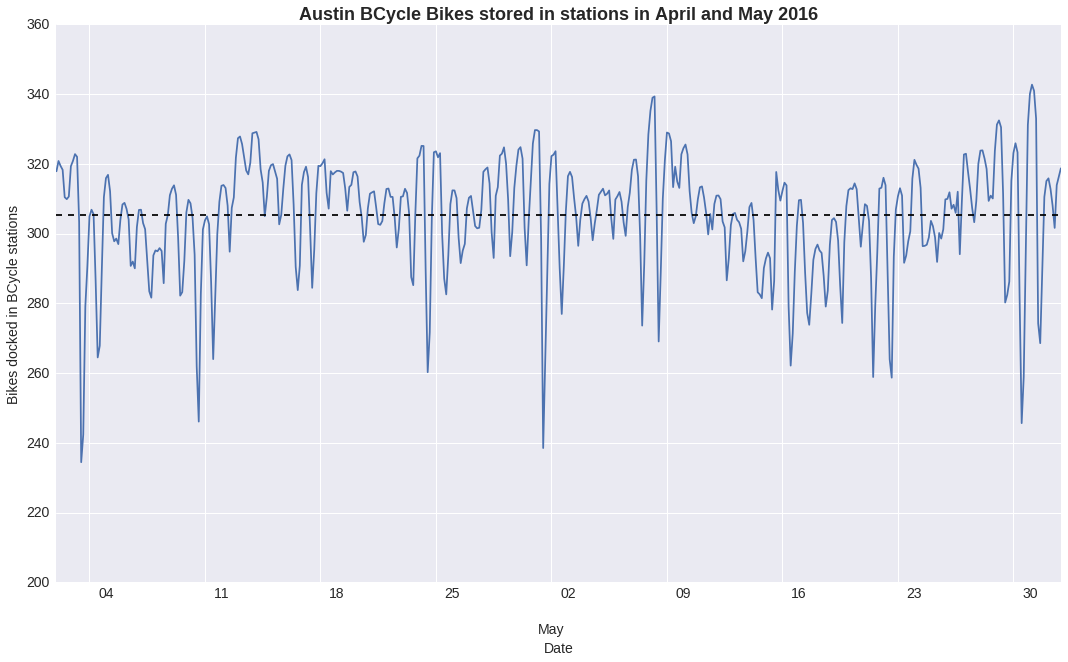

In [3]:
total_bikes_df = bikes_df.copy()
total_bikes_df = total_bikes_df.groupby('datetime').sum().reset_index()
total_bikes_df.index = total_bikes_df['datetime']
total_bikes_df = total_bikes_df.drop(['station_id', 'datetime', 'docks'], axis=1)

resampled_bikes_df = total_bikes_df.resample('3H').mean()
mean_bikes = resampled_bikes_df['bikes'].mean()
min_bikes = resampled_bikes_df['bikes'].min()
print('Mean bikes in BCycle stations: {:.0f}, minimum: {:.0f}'.format(mean_bikes, min_bikes))

xtick = pd.date_range( start=resampled_bikes_df.index.min( ), end=resampled_bikes_df.index.max( ), freq='W' )

fig, ax = plt.subplots(1,1, figsize=(18,10))
ax = resampled_bikes_df.plot(ax=ax, legend=None)
ax.axhline(y = mean_bikes, color = 'black', linestyle='dashed')
ax.set_xticks( xtick )
ax.set_ylim(ymin=200)
ax.set_xlabel('Date', fontdict={'size' : 14})
ax.set_ylabel('Bikes docked in BCycle stations', fontdict={'size' : 14})
ax.set_title('Austin BCycle Bikes stored in stations in April and May 2016', fontdict={'size' : 18, 'weight' : 'bold'})
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)



This plot shows the amount of bikes stored in stations varies on a daily basis around the mean of 305. There are sharp dips over the weekends, where active bikes increase sharply. With a minimum number of bikes stored in stations of 234, this means the BCycle network never comes close to running out of bikes across the entire system. But individual stations do (see the bcycle_stations notebook for more information). 

## Converting station bike levels to checkout and checkin information

Hadley Wickham has a great paper on [tidy data](http://vita.had.co.nz/papers/tidy-data.pdf) which gives guidelines on how to format data so it can be easily aggregated. The CSV file is already stored in a tidy data format (one measurement per line of docks and bikes), but to calculate checkins and checkouts I need to sort first by `station_id`, and then by `datetime`.

Once I have the sorting order corect, I can segment the dataframe by `station_id` and calculate the diffs between each sample (spaced at 5 minutes). In the event of a checkin, the amount of bikes increments, and the amount of docks decrements. For a checkout the reverse is true (bikes decrements, docks increments).

In [4]:
# Sort the bikes_df dataframe by station_id first, and then datetime so we
# can use a diff() and get the changes by time for each station
bikes_df = load_bikes()
bikes_df = bikes_df.sort_values(['station_id', 'datetime']).copy()
stations = bikes_df['station_id'].unique()

# Our dataframe is grouped by station_id first now, so grab each station in
# turn and do a diff() on bikes and docks for each station individually
diff_list = list()
for station in stations:
    station_diff_df = bikes_df[bikes_df['station_id'] == station].copy()
    station_diff_df['bikes_diff'] = station_diff_df['bikes'].diff()
    station_diff_df['docks_diff'] = station_diff_df['docks'].diff()
    diff_list.append(station_diff_df)

# Concatenate the station dataframes back together into a single one.
# Make sure we didn't lose any rows in the process (!)
bikes_diff_df = pd.concat(diff_list)

# The first row of each station-wise diff is filled with NaNs, store a 0 in these fields
# then we can convert the data type from floats to int8s 
bikes_diff_df.fillna(0, inplace=True)
bikes_diff_df[['bikes_diff', 'docks_diff']] = bikes_diff_df[['bikes_diff', 'docks_diff']].astype(np.int8)
bikes_diff_df.index = bikes_diff_df['datetime']
bikes_diff_df.drop('datetime', axis=1, inplace=True)
assert(bikes_df.shape[0] == bikes_diff_df.shape[0]) 
bikes_diff_df.describe()

,station_id,bikes,docks,bikes_diff,docks_diff
count,843126.000000,843126.000000,843126.000000,843126.000000,843126.000000
mean,24.602239,6.337278,6.311496,0.000004,-0.000009
std,13.912868,3.299118,3.356976,0.411478,0.411260
min,1.000000,0.000000,0.000000,-9.000000,-11.000000
25%,13.000000,4.000000,4.000000,0.000000,0.000000
50%,25.000000,6.000000,6.000000,0.000000,0.000000
75%,37.000000,8.000000,9.000000,0.000000,0.000000
max,50.000000,19.000000,19.000000,11.000000,9.000000


This table shows the distribution is heavily weighted towards 0 checkouts. The 1Q, median, and 3Q values are all 0 ! This makes sense intuitively, as there will be large amounts of 5-minute periods where individual stations don't have any checkouts or checkins, for example overnight. 

## Converting differences in bikes to checkouts and checkins

Now we have the differences in bikes every 5 minutes, we can calculate how many checkins and checkouts there were in 5 minutes. If the amount of bikes **decreases** (the difference is negative) then these represent **checkouts**. If the amount of bikes **increases** (the difference is positive) these are **checkins**.

We might want to treat checkouts and checkins independently in the analysis later on, so I 'll keep them separate for now. We can't just resample and sum the bike differences, otherwise the checkouts and checkins will balance themselves out, and we'll lose the true information.

In [5]:
bike_trips_df = bikes_diff_df.copy()

# Checkouts are all negative `bikes_diff` values. Filter these and take abs()
bike_trips_df['checkouts'] = bike_trips_df['bikes_diff']
bike_trips_df.loc[bike_trips_df['checkouts'] > 0, 'checkouts'] = 0
bike_trips_df['checkouts'] = bike_trips_df['checkouts'].abs()

# Conversely, checkins are positive `bikes_diff` values
bike_trips_df['checkins'] = bike_trips_df['bikes_diff']
bike_trips_df.loc[bike_trips_df['checkins'] < 0, 'checkins'] = 0
bike_trips_df['checkins'] = bike_trips_df['checkins'].abs()

# Might want to use sum of checkouts and checkins for find "busiest" stations
bike_trips_df['totals'] = bike_trips_df['checkouts'] + bike_trips_df['checkins']
bike_trips_df.head()

,station_id,bikes,docks,bikes_diff,docks_diff,checkouts,checkins,totals
datetime,,,,,,,,
2016-04-01 00:00:00,1,6,7,0,0,0,0,0
2016-04-01 00:05:00,1,6,7,0,0,0,0,0
2016-04-01 00:10:00,1,6,7,0,0,0,0,0
2016-04-01 00:15:00,1,6,7,0,0,0,0,0
2016-04-01 00:20:00,1,6,7,0,0,0,0,0


## Checkouts summed by day

Now I have the checkout and checkin information, I can plot how many daily checkouts there were during April and May 2016. Because the variation has a strong weekly component, I added day-of-the-week labels to the x axis. As the checkout patterns seem to be different on weekends compared to weekdays (more on this later), I highlighted weekend days in green, and weekdays in blue.

Median weekday checkouts: 478, median weekend checkouts: 766


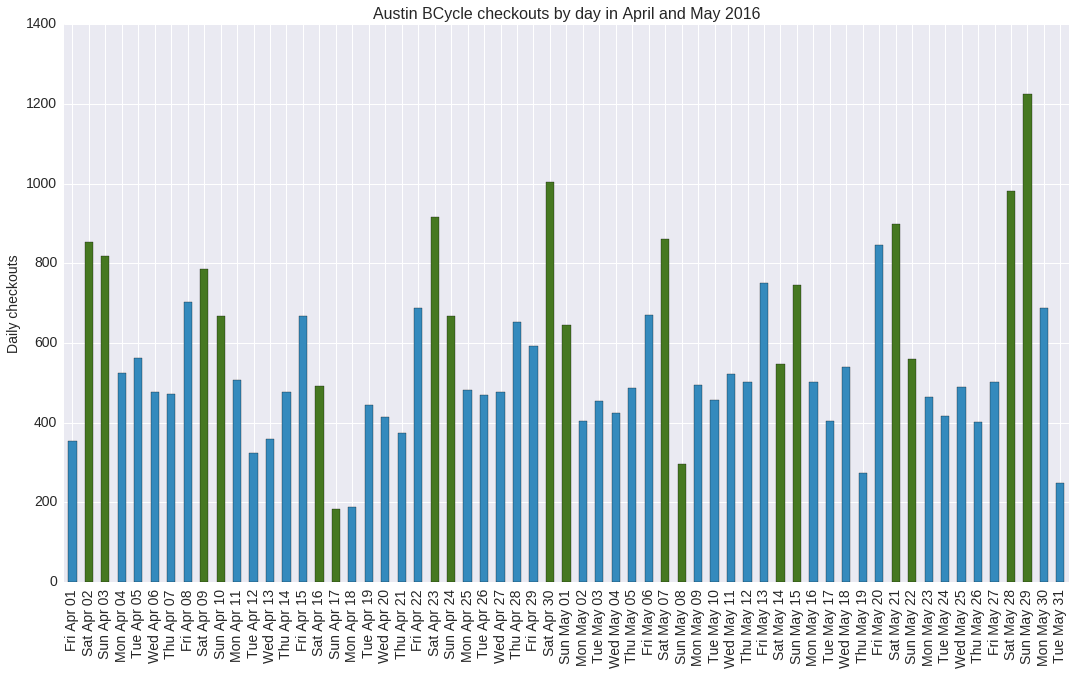

In [6]:
daily_bikes_df = bike_trips_df.copy()
daily_bikes_df = daily_bikes_df.reset_index()
daily_bikes_df = daily_bikes_df[['datetime', 'station_id', 'checkouts']]
daily_bikes_df = daily_bikes_df.groupby('datetime').sum()
daily_bikes_df = daily_bikes_df.resample('1D').sum()
daily_bikes_df['weekend'] = np.where(daily_bikes_df.index.dayofweek > 4, True, False)
daily_bikes_df['color'] = np.where(daily_bikes_df['weekend'], '#467821', '#348ABD')

median_weekday = daily_bikes_df.loc[daily_bikes_df['weekend'] == False, 'checkouts'].median()
median_weekend = daily_bikes_df.loc[daily_bikes_df['weekend'] == True, 'checkouts'].median()

print('Median weekday checkouts: {:.0f}, median weekend checkouts: {:.0f}'.format(median_weekday, median_weekend))

fig, ax = plt.subplots(1,1, figsize=(18,10))
ax = daily_bikes_df['checkouts'].plot.bar(ax=ax, legend=None, color=daily_bikes_df['color'])
ax.set_xticklabels(daily_bikes_df.index.strftime('%a %b %d'))

ax.set_xlabel('', fontdict={'size' : 14})
ax.set_ylabel('Daily checkouts', fontdict={'size' : 14})
ax.set_title('Austin BCycle checkouts by day in April and May 2016', fontdict={'size' : 16})
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

The plot shows that at a high level, the amount of checkouts is noticeably higher on weekends than during the week. The median checkout number is 766 on weekends vs 478 on weekdays. There are also quite a few days where the checkouts unexpectedly dropped (for example 17-18 April), this may be due to bad weather. I'm planning on correlating weather to checkouts in upcoming articles. 

Monday May 30th is a national holiday in the US (Memorial Day), and the weekend checkouts before May 30th were higher than other weekends. On Memorial day itself, there were many more checkouts than on the other Mondays.

## Boxplot of checkouts by day

To get a better idea of the variation of bike checkouts by day, we can use a boxplot to visualize their distribution on each of the days.

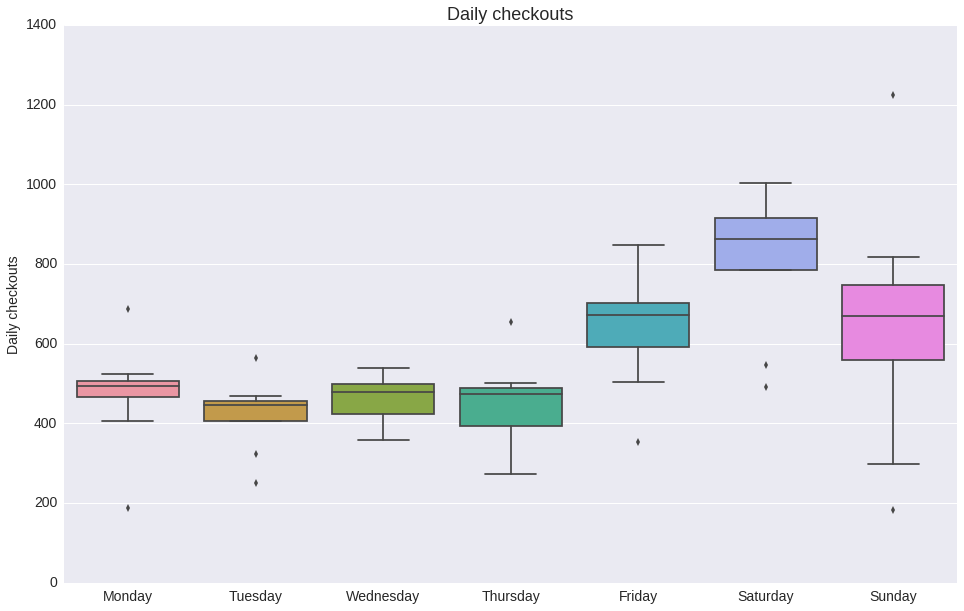

In [7]:
boxplot_trips_df = daily_bikes_df.copy()
boxplot_trips_df = boxplot_trips_df.reset_index()
boxplot_trips_df['weekday_name'] = boxplot_trips_df['datetime'].dt.weekday_name
boxplot_trips_df = boxplot_trips_df[['weekday_name', 'checkouts']]

day_names=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig, ax = plt.subplots(1,1, figsize=(16,10))  
ax = sns.boxplot(data=boxplot_trips_df, x="weekday_name", y="checkouts", order=day_names)
ax.set_xlabel('', fontdict={'size' : 14})
ax.set_ylabel('Daily checkouts', fontdict={'size' : 14})
ax.set_title('Daily checkouts', fontdict={'size' : 18})
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)

This boxplot confirms some of the observations from the 'Checkouts by day' bargraph above. The distributions of checkouts from Monday to Thursday are all very similar, with a median of just under 500. These trips are likely commuter traffic, so BCyclers saved around 500 car trips every day during the week. Not bad !

Friday shows an uptick in checkouts, with the median value closer to 700. The extra 200 or so trips might account for extra trips out on Friday night for drinks or a meal. 

Saturday has the highest amount of checkouts, I suspect this is due to a combination of recreational use during the day (for example cycling around the Lady Bird Lake trail, or going shopping downtown) combined with cycling to and from bars at night-time.

Sunday shows a similar distribution to Friday, but with a much lower bottom "whisker" around 300 trips. I think this may be because Sunday has similar recreational users during the day, but with far fewer night trips as people have work on Monday.

There are also numerous outliers on this plot (see the dots above and below the main box-and-whisker area), these may be caused by bad weather for the low outliers. The high outliers also may be explained by people using BCycles to go to special events like music or sports events.

## Checkouts based on the day of the week, and time

Now we have the amount of checkouts from each station every 5 minutes in April/May, we can look into the checkout patterns in more detail. To get a feel for how the checkouts vary by time, we can add up checkouts over all the stations and see how they vary depending on the time and day-of-the week. As we're plotting the data by hour, we can sum up all the checkouts per hour.

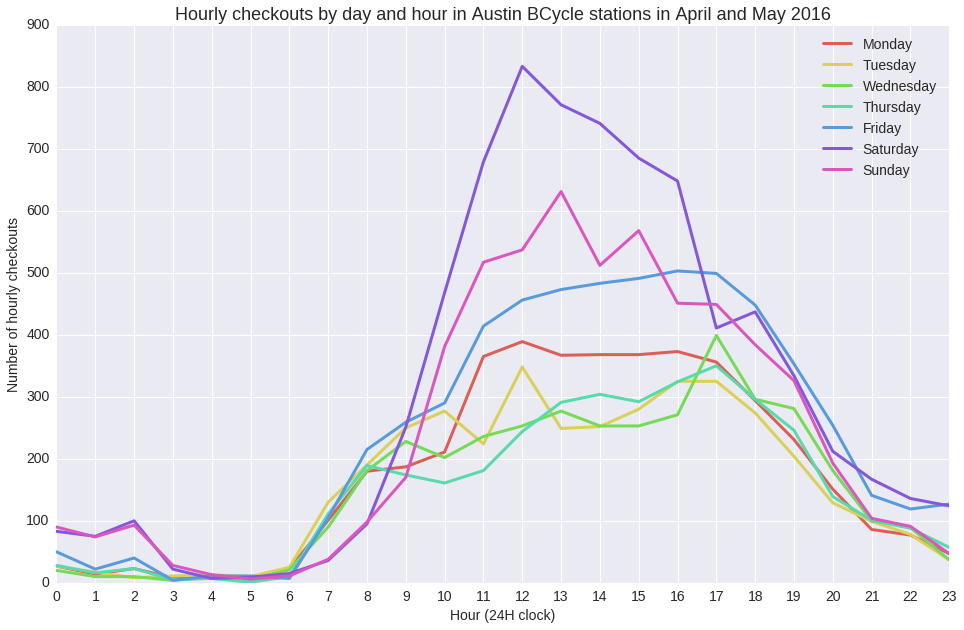

In [8]:
checkouts_df = bike_trips_df.copy()
checkouts_df = checkouts_df.reset_index()
checkouts_df['dayofweek'] = checkouts_df['datetime'].dt.weekday_name
checkouts_df['hour'] = checkouts_df['datetime'].dt.hour
checkouts_df = checkouts_df.groupby(['dayofweek', 'hour']).sum().reset_index()
checkouts_df = checkouts_df[['dayofweek', 'hour', 'checkouts']]
checkouts_df = checkouts_df.pivot_table(values='checkouts', index='hour', columns='dayofweek')

checkouts_df = checkouts_df[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
day_palette = sns.color_palette("hls", 7) # Need to have 7 distinct colours

fig, ax = plt.subplots(1,1, figsize=(16,10))
ax = checkouts_df.plot.line(ax=ax, linewidth=3, color=day_palette)
ax.set_xlabel('Hour (24H clock)', fontdict={'size' : 14})
ax.set_ylabel('Number of hourly checkouts', fontdict={'size' : 14})
ax.set_title('Hourly checkouts by day and hour in Austin BCycle stations in April and May 2016'
             ,fontdict={'size' : 18})
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.xaxis.set_ticks(checkouts_df.index)
ax.legend(fontsize=14)


This plot shows a lot of useful information on the checkouts-per-hour. Let's unpack it:

* The amount of checkouts during the day (9AM to midnight) is roughly the same for Tuesday, Wednesday, and Thursday (around 300 checkouts per hour during the day). Friday follows these days up until around 10AM, when the number of checkouts rises steadily to hit 500 per hour at 5PM. This could be caused by people cycling to Happy Hours after work on a Friday, or going out after work. The weekend days (Saturday and Sunday) have higher peaks of bike checkouts during the day (~610 on Sunday, and ~825 on Saturday).


* The time between 6AM and 9AM shows the difference between commuting trips on the weekdays, and recreational use on the weekends. The weekday checkouts start increasing at 6AM, hitting 200 checkouts per hour at 8AM as people head into work for the day. The good people of Austin take a well-earned lie in on the weekend, taking until 9AM to hit 200 checkouts per hour, with a shallower increase. On Saturday and Sunday there are also ~100 checkouts per hour up until 2AM-3AM, so they probably need a lie-in after having a few beers the night before.

## Checkouts by station on weekdays and weekends

Now we have an idea of how the checkouts vary by time, we can look at how they vary by station. A heatmap shows how many checkouts there are for each of the 50 stations for each hour-of-the day. As there seem to be different patterns for weekdays and weekends, let's plot these separately and compare.

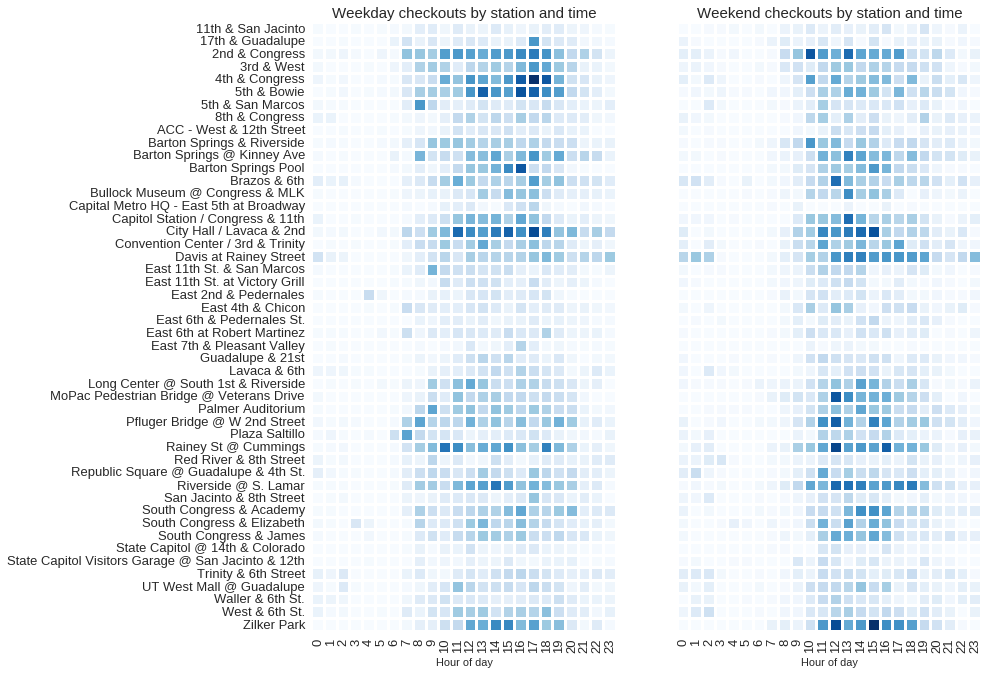

In [9]:
heatmap_df = bike_trips_df.copy()

heatmap_df = heatmap_df.reset_index()
heatmap_df['dayofweek'] = heatmap_df['datetime'].dt.dayofweek
heatmap_df['hour'] = heatmap_df['datetime'].dt.hour
heatmap_df['weekday'] = heatmap_df['datetime'].dt.dayofweek < 5
heatmap_df = heatmap_df.groupby(['weekday', 'station_id', 'hour']).sum().reset_index()
heatmap_df = heatmap_df[['weekday', 'station_id', 'hour', 'checkouts']]
heatmap_df = heatmap_df[heatmap_df['station_id'] < 49]

heatmap_df = pd.merge(heatmap_df, stations_df[['station_id', 'name']])

weekday_df = heatmap_df[heatmap_df['weekday']].pivot_table(values='checkouts', index='name', columns='hour')
weekend_df = heatmap_df[~heatmap_df['weekday']].pivot_table(values='checkouts', index='name', columns='hour')

weekday_df = weekday_df / 5.0 # Normalize checkouts by amount of days
weekend_df = weekend_df / 2.0

weekday_max = weekday_df.max().max() # Take max over stations and hours
weekend_max = weekend_df.max().max() # Take max over stations and hours

fig, ax = plt.subplots(1, 2, figsize=(12,20))
sns.heatmap(data=weekday_df, robust=True, ax=ax[0], linewidth=2, square=True, vmin=0, vmax=weekday_max, cbar=False, cmap='Blues')
ax[0].set_xlabel('Hour of day')
ax[0].set_ylabel('')
ax[0].set_title('Weekday checkouts by station and time', fontdict={'size' : 15})
ax[0].tick_params(axis='x', labelsize=13)
ax[0].tick_params(axis='y', labelsize=13)

sns.heatmap(data=weekend_df, robust=True, ax=ax[1], linewidth=2, square=True, vmin=0, vmax=weekend_max, cbar=False, cmap='Blues', yticklabels=False)
ax[1].set_xlabel('Hour of day')
ax[1].set_ylabel('')
ax[1].set_title('Weekend checkouts by station and time', fontdict={'size' : 15})
ax[1].tick_params(axis='x', labelsize=13)
ax[1].tick_params(axis='y', labelsize=13)


There's a lot going on in this plot ! I didn't include this in the articles because it's too busy. Working from top to bottom, there are some interesting trends though. See if you can spot which stations are busiest for weekday commutes vs the weekends.

## Plotting checkouts on a map, by time

Now let's visualize the busiest stations in the system on separate maps, by time. We'll group the checkouts and sum them together for each 3-hour window, and produce 8 maps for each of the 3-hour periods. We'll separate the stations by weekdays and weekends.

In [10]:
# Initial setup for the visualization
map_df = bike_trips_df.copy()

map_df = map_df.reset_index()
map_df['dayofweek'] = map_df['datetime'].dt.dayofweek
map_df['hour'] = map_df['datetime'].dt.hour
map_df['3H'] = (map_df['hour'] // 3) * 3
map_df['weekday'] = map_df['datetime'].dt.dayofweek < 5

map_df = map_df.groupby(['weekday', 'station_id', '3H']).sum().reset_index()
map_df = map_df[['weekday', 'station_id', '3H', 'checkouts']]
map_df = map_df[map_df['station_id'] < 49] # Stations 49 and 50 were only open part of the time

map_df.loc[map_df['weekday'] == False, 'checkouts'] = map_df.loc[map_df['weekday'] == False, 'checkouts'] / 2.0
map_df.loc[map_df['weekday'] == True, 'checkouts'] = map_df.loc[map_df['weekday'] == True, 'checkouts'] / 5.0


map_df = pd.merge(map_df, stations_df[['station_id', 'name', 'lat', 'lon']])

# Calculate where the map should be centred based on station locations
min_lat = stations_df['lat'].min()
max_lat = stations_df['lat'].max()
min_lon = stations_df['lon'].min()
max_lon = stations_df['lon'].max()
center_lat = min_lat + (max_lat - min_lat) / 2.0
center_lon = min_lon + (max_lon - min_lon) / 2.0

# map_df.head(10)

### Saving bike activity to 3-hourly maps

Now the data has been manipulated, let's save out the HTML for each of the maps. This might take a miute or two to save out all the files, 

In [11]:
from tqdm import tqdm

# Plot the resulting data on a map
# Hand-tuned parameter to control circle size
K = 3
C = 2

hours = range(0, 24, 3)

for weekday in (False, True):
    if weekday:
        days = 'weekdays'
    else:
        days = 'weekends'
        
    for hour in tqdm(hours, desc='Generating maps for {}'.format(days)):
        hour_df = map_df[(map_df['weekday'] == weekday) & (map_df['3H'] == hour)]

        map = folium.Map(location=(center_lat, center_lon), 
                     zoom_start=14, 
                     tiles='Stamen Toner',
                     control_scale=True)

        for station in hour_df.iterrows():
            stat = station[1]
            folium.CircleMarker([stat['lat'], stat['lon']], radius=(stat['checkouts'] * K) + C,
                                popup='{} - {} checkouts @ {}:00 - {}:00'.format(stat['name'], stat['checkouts'], stat['3H'], stat['3H']+3),
                                fill_color='blue', fill_opacity=0.8
                               ).add_to(map)

        if weekday:
            filename='weekday_{}.html'.format(hour)
        else:
            filename='weekend_{}.html'.format(hour)

        map.save(filename)
    
print('Completed map HTML generation!')

Generating maps for weekdays: 100%|██████████| 8/8 [00:13<00:00,  1.69s/it]

Completed map HTML generation!
